In [0]:
!pip install gym
!pip install gym[atari]

In [0]:
class BreakoutEnvHelper():
  
  # horizontal zone for data to extract
  x_min = 8
  x_max = 151
  # vertical zone for the ball
  y_min_balle = 93
  y_max_balle = 188
  # line for the palet
  y_palet = 189
  
  hist_balle_x = 0
  hist_balle_y = 0
  
  step = 10
  
  def __init__(self, step = 10):
    print("extract_state, step=", step)
    self.step = step
    
  def x_len(self):
    return int((self.x_max - self.x_min)/self.step)+1
  
  def y_len(self):
    return int((self.y_max_balle - self.y_min_balle)/self.step)+1
  
  def extract_state(self, obs):
    # position du palet
    palet_x = np.argmax(obs[:,self.x_min:self.x_max+1,0:1][self.y_palet])
    # position de la balle
    zone_balle = obs[self.y_min_balle:self.y_max_balle+1,self.x_min:self.x_max+1,0:1]
    balle_xy = np.unravel_index(np.argmax(zone_balle, axis=None), zone_balle.shape)
  
    # print("extract_state: --> ", int(balle_xy[1]/self.step), int(balle_xy[0]/self.step), int(palet_x/self.step))
    return np.array([int(balle_xy[1]/self.step), int(balle_xy[0]/self.step), int(palet_x/self.step)])
  
  def extract_state_and_speed(self, obs, t):
    balle_x, balle_y, palet_x = self.extract_state(obs)
    if t == 0:
      self.hist_balle_x = balle_x
      self.hist_balle_y = balle_y
    
    speed = np.linalg.norm([balle_x - self.hist_balle_x, balle_y - self.hist_balle_y])
    
    self.hist_balle_x = balle_x
    self.hist_balle_y = balle_y
    
    print("extract_state_and_speed: --> ", balle_x, balle_y, palet_x, speed, balle_x - self.hist_balle_x, balle_y - self.hist_balle_y)
    return ( balle_x, balle_y, palet_x, speed, balle_x - self.hist_balle_x, balle_y - self.hist_balle_y ) 

In [0]:
class QLearning:
    def __init__(self, br, n_rows, n_cols, n_actions, gamma, epsilon=1, debug=False):
        """
        Q Learning algorithm for gym atari env 'breakout'.
        br: BreakoutEnvHelper (to translate positions in grid)
        n_rows: number of y positions for the ball.
        n_cols: number of x positions, for the ball, and for the pad.
        n_actions: number of possible actions.
        State consists of (x_ball, y_ball, x_pad, actions)
         (with sizes (n_cols, n_rows, n_cols, n_actions))

        Parameters
        ----------
        n_rows : int
            Number of rows
        n_cols : int
            Number of columns
        n_actions : int
            Number of actions
        gamma : float
            Discount factor in [0, 1]
        epsilon : float
            Probability of a random action (epsilon-greedy)
        """
        self.epsilon = epsilon
        self.q = np.zeros((n_cols, n_rows, n_cols, n_actions))
        print("Q ", self.q.shape, "--> (x_balle, y_balle, x_palet)")
        self.gamma = gamma
        self.helper = br
        self.debug = debug

    @property
    def n_actions(self):
        return self.q.shape[-1]
      
    def get_q(self):
        return self.q

    def fit_step(self, s, a, r, s_new):
        """

        Parameters
        ----------
        s : array-like
            State before action
        a : int
            Action index
        r : int or float
            Immediate reward
        s_new : array-like
            State after action
        """
        
        q_max = np.max(self.q[s_new[0], s_new[1], s_new[2], :])
        q_new = r + self.gamma * q_max
        self.q[s[0], s[1], s[2], a] = q_new
        if self.debug: print("QLeaning.fit_step(s={s}, a={a}, r={r}, s_new={s_new} ==> q({s}, {a}) <-- {q_new}"
             .format(s=s, a=a, r=r, s_new=s_new, q_new=q_new))

    def choose_action(self, s):
        """

        Parameters
        ----------
        s : array-like
            State where to choose an action

        Returns
        -------
        int
            Action index

        """
        if np.random.rand() < self.epsilon:
          return np.random.randint(0, self.n_actions()) # fully random choice
        else:
          return np.argmax(self.q[s[0], s[1], s[2], :])
        
    def run_episode(self, initial_state, env, max_episodes=1000):
        """
        Run the algorithm for one episode

        Parameters
        ----------
        initial_state : array-like
            Initial state for the episode / useless for breakout
        step_function : function
            Function of the form `step(s, a)` that performs an action `a` in a
            state `s` and returns a triplet `(s_new, r, end_episode)`.

        """
        
        obs = env.reset()
        s = self.helper.extract_state(obs)
        end_episode = False
        t = 0
        rewards = 0
        print("start")
        while not end_episode and t < max_episodes:
            # env.render() # needs a display
            a = self.choose_action(s)
            if self.debug: print(" > action ", a) # does not work ... env.env.get_action_meanings[a])
            obs, r, end_episode, info = env.step(a)
            rewards = rewards + r
            s_new = self.helper.extract_state(obs)
            if self.debug: print("step: new state ", s_new, "reward ", r, "info", info, "end_episode ", end_episode)
            self.fit_step(s, a, r, s_new)
            s = s_new
            t = t + 1
        print("Done ", t, " iterations")
        if info['ale.lives'] == 0:
          print("episode FAILED")
          return (False, t, rewards)
        else:
          print("episode SUCCESS")
          return (True, t, rewards)


In [0]:
import gym
import numpy as np

n_episodes = 1000
max_episodes = 5000

 
br = BreakoutEnvHelper(step=10)
              
env = gym.make('Breakout-v0')
qlearning = QLearning(br, br.y_len(), br.x_len(), env.action_space.n, gamma=0.99, epsilon = 0.3, debug=False)
       
iters = []

results = []
allrewards = []
mean_rewards = []
      
for i in range(n_episodes):
    print("episode ", i)
    result, iter, rewards = qlearning.run_episode('', env, max_episodes)
    iters.append(iter)
    results.append(result)
    allrewards.append(rewards)
    if i == 0:
      mean_rewards.append(rewards)
    else:
      mean_rewards.append(mean_rewards[i-1] + (rewards - mean_rewards[i-1]) / i)


extract_state, step= 10


/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Q  (15, 10, 15, 4) --> (x_balle, y_balle, x_palet)
episode  0
start
Done  301  iterations
episode FAILED
episode  1
start
Done  291  iterations
episode FAILED
episode  2
start
Done  372  iterations
episode FAILED
episode  3
start
Done  283  iterations
episode FAILED
episode  4
start
Done  280  iterations
episode FAILED
episode  5
start
Done  352  iterations
episode FAILED
episode  6
start
Done  360  iterations
episode FAILED
episode  7
start
Done  265  iterations
episode FAILED
episode  8
start
Done  272  iterations
episode FAILED
episode  9
start
Done  305  iterations
episode FAILED
episode  10
start
Done  328  iterations
episode FAILED
episode  11
start
Done  165  iterations
episode FAILED
episode  12
start
Done  351  iterations
episode FAILED
episode  13
start
Done  267  iterations
episode FAILED
episode  14
start
Done  339  iterations
episode FAILED
episode  15
start
Done  299  iterations
episode FAILED
episode  16
start
Done  197  iterations
episode FAILED
episode  17
start
Done  

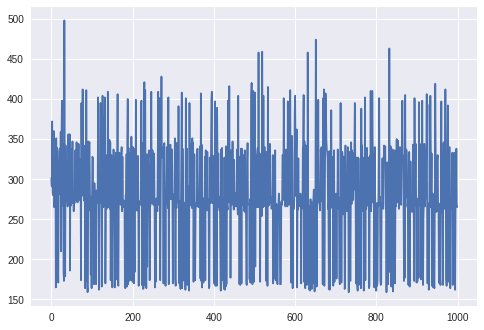

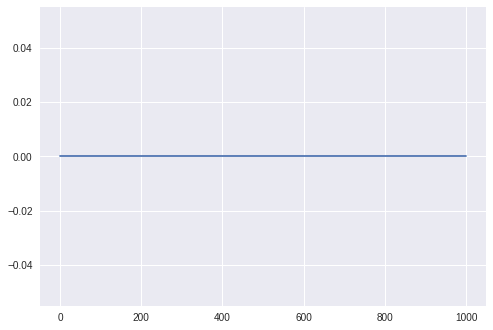

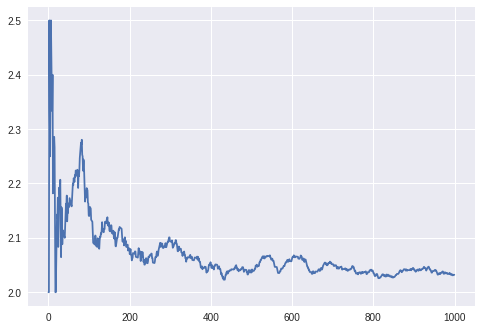

In [0]:
import matplotlib.pyplot as plt

plt.plot(iters)
plt.show()
plt.plot(results)
plt.show()
plt.plot(mean_rewards)
plt.show()

In [0]:
q = qlearning.get_q()
print(np.unique(q, return_counts=True))

import pandas as pd
df = pd.DataFrame(np.vstack((np.unique(q, return_counts=True)[0], np.unique(q, return_counts=True)[1])))
df

(array([0.00000000e+00, 9.34387838e-22, 1.16798480e-21, ...,
       1.44063481e+00, 1.51250829e+00, 1.80193668e+00]), array([7957292,       1,       1, ...,       1,       1,       1]))


,0,1,2,3,4,5,6,7,8,9,...,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559
0,0.0,9.343878e-22,1.167985e-21,2.281220e-21,2.124552e-20,4.149516e-20,8.958979e-12,2.734063e-11,2.546295e-10,7.770676e-10,...,1.004728,1.062352,1.068719,1.068979,1.128154,1.152326,1.313549,1.440635,1.512508,1.801937
1,7957292.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
env = gym.make('Breakout-v0') 
obs = env.reset()

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [0]:
br = BreakoutEnvHelper()

extract_state, step= 10


In [0]:
obs = env.reset()
for i in range(1000):
  br.extract_state_and_speed(obs, i)
  obs, r, end_episode, debug = env.step(np.random.randint(4))
  print(r, end_episode, debug)

extract_state_and_speed: -->  0 0 9 0.0 0 0
0.0 False {'ale.lives': 5}
extract_state_and_speed: -->  0 0 7 0.0 0 0
0.0 False {'ale.lives': 5}
extract_state_and_speed: -->  6 3 7 6.708203932499369 0 0
0.0 False {'ale.lives': 5}
extract_state_and_speed: -->  6 3 6 0.0 0 0
0.0 False {'ale.lives': 5}
extract_state_and_speed: -->  6 3 6 0.0 0 0
0.0 False {'ale.lives': 5}
extract_state_and_speed: -->  5 4 5 1.4142135623730951 0 0
0.0 False {'ale.lives': 5}
extract_state_and_speed: -->  5 4 3 0.0 0 0
0.0 False {'ale.lives': 5}
extract_state_and_speed: -->  5 4 2 0.0 0 0
0.0 False {'ale.lives': 5}
extract_state_and_speed: -->  4 5 1 1.4142135623730951 0 0
0.0 False {'ale.lives': 5}
extract_state_and_speed: -->  4 5 1 0.0 0 0
0.0 False {'ale.lives': 5}
extract_state_and_speed: -->  4 5 1 0.0 0 0
0.0 False {'ale.lives': 5}
extract_state_and_speed: -->  3 6 1 1.4142135623730951 0 0
0.0 False {'ale.lives': 5}
extract_state_and_speed: -->  3 6 0 0.0 0 0
0.0 False {'ale.lives': 5}
extract_state_and_

In [0]:
obs, r, end_episode, debug = env.step(3)

In [0]:
print(obs.shape)

(210, 160, 3)


In [0]:
(128, 40, 19)
(131, 43, 22)
(121, 45, 24)
(111, 47, 26)
(93, 50, 29)

In [0]:
print(env.action_space.n)

4
